# Fast Gradient Method Attack and Binary Input Detector Using MNIST10

This notebook shows the Fast Gradient Method attack implmentation using the ART library against deep learning models trained on MNIST-10 dataset. The notebook covers the following:

* Load the required libariries
* Load the dataset and inspect the data
* Create a deep learning model
* Train and evaluate the deep learning model on CIFAR test data
* Implement FGSM attack using ART
* Create adversarial samples using the FGSM attack
* Evaluate the deep leaarning model against the adversaarial samples
* Create a detector model to detect adversarial samples
* Train and evaluate the detector model

### **Fast Gradient Sign Method (FGSM) Attack - Overview**

The Fast Gradient Sign Method (FGSM) is one of the *simplest and most widely used techniques* for generating adversarial examples. It was introduced by **Ian Goodfellow et al**. in 2014 as a method to quickly generate adversarial examples to evaluate the vulnerability of machine learning models, particularly neural networks.

The core idea of FGSM is to perturb the original input data by a small amount in the direction that maximizes the model's loss, using the gradient of the loss function with respect to the input. This causes the model to misclassify the perturbed input while keeping the perturbation small enough to not be easily detected.


#### **Key Concepts:**

* **Adversarial Example:** A carefully crafted input that is designed to make a model misclassify it.
* **Loss Function:** The function that measures how well the model's predictions align with the true labels. In the context of classification, the loss is typically the cross-entropy loss.
* **Gradient:** The gradient of the loss with respect to the input indicates how the loss changes as the input is perturbed. By moving the input in the direction of this gradient, we can increase the loss and cause the model to make a wrong prediction.

#### **Steps in the FGSM Attack**

**1. Initialization:**
* Start with an original input $x$ and the true label $y$.
* Calculate the loss $J(x,y)$ (often cross-entropy loss) of the model on the original input.

**2. Compute the Gradient:**
* Compute the gradient of the loss $J(x,y)$ with respect to the input $x$:
$$∇_{x}J(x,y)$$

This gives us the direction in which the input needs to be perturbed to increase the loss, i.e., in the direction that the model is most sensitive to.

**3. Perturbation Calculation:**
    * The perturbation is applied by moving the input in the direction of the gradient. However, to simplify, we only use the **sign** of the gradient instead of the full gradient to create a smaller, more targeted perturbation:
    $$Perturbation=ϵ⋅sign(∇_{x}J(x,y))$$

**Where:**
- $ϵ$ is a small scalar that controls the magnitude of the perturbation.
- $sign(∇_{x}J(x,y))$ means we only take the sign of each component of the gradient, not the magnitude.

**4. Adversarial Example:**
* The final adversarial example is created by adding the perturbation to the original input:
$$x_{adv}=x+ϵ⋅sign(∇_{x}J(x,y))$$

Here, $x_{adv}$​ is the adversarial example, which is a slightly modified version of the original input that should be classified incorrectly by the model.

**5. Projection (if necessary):**
* In some cases, especially when working with image data, we may want to ensure the perturbed image stays within the valid range (e.g., pixel values between 0 and 255 for images). However, this projection is often implicit in the FGSM approach, as it doesn't strictly require a projection step like iterative attacks (e.g., PGD).

#### **Formula Breakdown**

The **FGSM attack** formula is:
$$x_{adv}=x+ϵ⋅sign(∇_{x}J(x,y))$$

- $x$: The original input (for example, an image).
- $ϵ$: A small scalar value that determines the magnitude of the perturbation. It controls the strength of the adversarial attack. A larger ϵϵ will create a more significant perturbation, while a smaller ϵϵ will result in a more subtle perturbation.
- $∇_{x}J(x,y)$: The gradient of the loss function $J(x,y)$ with respect to the input $x$. This gradient indicates how the model's prediction changes as the input changes.
- $sign(∇_{x}J(x,y))$: The element-wise sign of the gradient, which means each component of the gradient is replaced by either +1, -1, or 0, depending on whether the corresponding component of the gradient is positive, negative, or zero. This makes the perturbation a small, focused change in the input.

#### **How FGSM Works During the Attack**

**1. Start with the original input:** 

We begin with an input image $x$ and its true label $y$.

**2. Compute the loss and gradient:**
* Calculate the model’s loss $J(x,y)$, which measures how far the model's prediction is from the true label $y$.
* Compute the gradient $∇_{x}J(x,y)$, which gives us the direction in which the model is most sensitive to the input. The gradient essentially tells us how the model's loss changes with small changes to the input.

**3. Create the perturbation:**
* We take the sign of the gradient $sign(∇_{x}J(x,y))$ to create a binary signal (positive or negative), and multiply it by the perturbation size $ϵ$. This ensures that we only make small, targeted changes to the input.

**4. Generate the adversarial example:**
* The adversarial example is generated by adding the perturbation to the original input:
$$x_{adv}=x+ϵ⋅sign(∇_{x}J(x,y))$$
* The resulting adversarial example xadvxadv​ is very similar to the original input but modified in a way that causes the model to make an incorrect prediction.

**5. Classify the adversarial example:**
* The adversarial example $x_{adv}$ is then passed to the model for classification. Due to the targeted perturbation, the model is likely to misclassify this example, even though the perturbation is small enough to be imperceptible to the human eye (especially in the case of images).

#### **Why FGSM is Fast**

FGSM is considered a "fast" attack because it only requires a single gradient computation and a straightforward update step. The method is efficient and can generate adversarial examples quickly, making it ideal for evaluating the robustness of models. It contrasts with iterative methods (like PGD), which require multiple gradient updates and are computationally more expensive.

#### **Strengths and Weaknesses of FGSM**
**Strengths:**

* **Simplicity**: The method is simple to implement and understand. It requires only a single pass through the model to compute the gradient and generate the perturbation.
* **Speed**: Since it only involves a single gradient computation, FGSM can generate adversarial examples much faster than iterative attacks like PGD.
* **Effectiveness**: Despite its simplicity, FGSM is often effective at causing misclassification, especially when the model is vulnerable.

**Weaknesses:**

* **Weak Attack**: Since it only performs one update step and does not iteratively refine the perturbation, FGSM may not be as effective against more robust models. It may not generate adversarial examples that are as strong as those created by iterative methods.
* **Sensitivity to $ϵ$**: The strength of the attack depends on the choice of $ϵ$. Too small a value might not cause misclassification, while too large a value might make the perturbation visible to humans, especially for image data.

## Install and load required libraries 

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector

2025-01-27 10:34:42.315724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 10:34:42.424623: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus))
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

3
3 Physical GPUs, 1 Logical GPU


2025-01-27 10:34:50.581158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 10:34:50.847479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23935 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6


In [3]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

### Load MNIST dataset

In [5]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = np.load('./../Datasets/mnist10_dataset.npy', allow_pickle = True)
x_train, x_test = x_train / 255.0, x_test/ 255.0
min = x_train.min()
max = x_train.max()
x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 0.0, 1.0)

### Inspect the Data

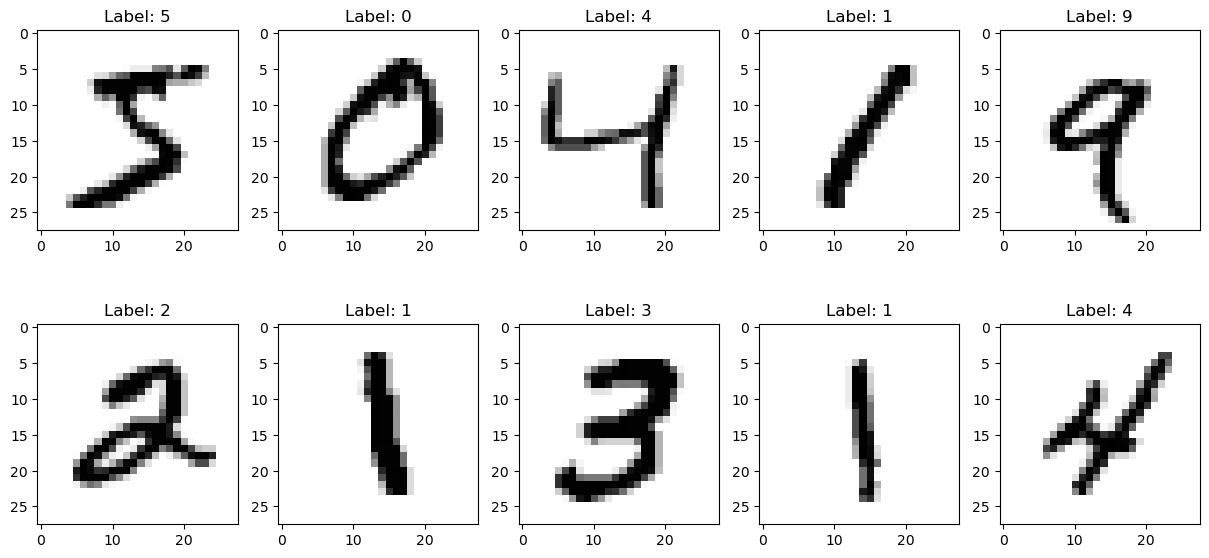

In [6]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image, cmap="gray_r")
  ax[i].set_title(f"Label: {label}",  fontsize=12)

In [7]:
nb_classes =10
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)
x_test = np.expand_dims(x_test, axis=-1)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
x_train = np.expand_dims(x_train, axis=-1)

## TensorFlow with Keras API

Create a model using Keras API. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics.

In [8]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
loss_ = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy']);

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

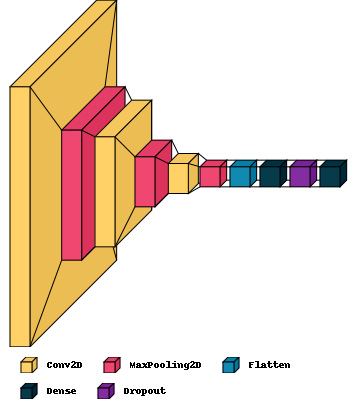

In [27]:
import visualkeras
visualkeras.layered_view(model, scale_xy=10, legend=True)

In [24]:
# tf.keras.utils.plot_model(model, show_shapes=True)

### Fit the model on training data.

In [15]:
history = model.fit(x_train, y_train, epochs=3)

Train on 60000 samples


2025-01-21 15:31:30.211264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42002 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:d5:00.0, compute capability: 8.6
2025-01-21 15:31:30.316932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Epoch 1/3


2025-01-21 15:31:31.237784: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/dense_1/kernel/m/Assign' id:375 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/kernel/m, training/Adam/dense_1/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-21 15:31:31.540504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2025-01-21 15:31:31.838883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60000/60000 [==============================] - 25s 411us/sample - loss: 0.2193 - accuracy: 0.9326
Epoch 2/3
60000/60000 [==============================] - 22s 372us/sample - loss: 0.0744 - accuracy: 0.9771
Epoch 3/3
60000/60000 [==============================] - 25s 417us/sample - loss: 0.0545 - accuracy: 0.9844


In [25]:
# model.save('./../Models/mnist10_model.keras')
model = tf.keras.models.load_model('./../Models/mnist10_model.keras')
model.summary()

2025-01-21 15:34:00.393318: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_2_1/bias/Assign' id:601 op device:{requested: '', assigned: ''} def:{{{node conv2d_2_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_2_1/bias, conv2d_2_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-21 15:34:00.693588: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/kernel/v/Assign' id:915 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1_1/kernel/v, dense_1_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will tr

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

### Evaluate model accuracy on test data.

In [26]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2025-01-21 15:34:03.298319: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:784 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on test data: 98.73%


### Create a ART Keras classifier.

In [28]:
# after normalizing the data
min = 0
max = 1 # before normalizing, it was 255

classifier = KerasClassifier(model=model, clip_values=(min, max))

## Fast Gradient Method (FGM)
> class art.attacks.evasion.FastGradientMethod(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, minimal: bool = False, summary_writer: str | bool | SummaryWriter = False)

This attack was originally implemented by Goodfellow et al. (2015) with the infinity norm (and is known as the “Fast Gradient Sign Method”). This implementation extends the attack to other norms, and is therefore called the Fast Gradient Method.
* Paper link: https://arxiv.org/abs/1412.6572

*\_\_init__(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, minimal: bool = False, summary_writer: str | bool | SummaryWriter = False) → None*

**Create a FastGradientMethod instance.**

     Parameters:
* estimator – A trained classifier.
* norm – The norm of the adversarial perturbation. Possible values: “inf”, np.inf, 1 or 2.
* eps – Attack step size (input variation).
* eps_step – Step size of input variation for minimal perturbation computation.
* targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False)
* num_random_init (int) – Number of random initialisations within the epsilon ball. For random_init=0 starting at the original input.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* minimal (bool) – Indicates if computing the minimal perturbation (True). If True, also define eps_step for the step size and eps for the maximum perturbation.
* summary_writer – Activate summary writer for TensorBoard. Default is False and deactivated summary writer. If True save runs/CURRENT_DATETIME_HOSTNAME in current directory. If of type str save in path. If of type SummaryWriter apply provided custom summary writer. Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’, ‘runs/exp2’, etc. for each new experiment to compare across them.

    
**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**

Generate adversarial samples and return them in an array.

    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). Only provide this parameter if you’d like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the “label leaking” effect (explained in this paper: https://arxiv.org/abs/1611.01236). Default is None.

* mask (np.ndarray) – An array with a mask broadcastable to input x defining where to apply adversarial perturbations. Shape needs to be broadcastable to the shape of x and can also be of the same shape as x. Any features for which the mask is zero will not be adversarially perturbed.

        Returns:
* An array holding the adversarial examples.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm


### Create an ART Fast Gradient Sign Method attack.

In [29]:
# eps – defines the attack step size (input variation). The smaller the eps, the little the attack scale would be.
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2)

### Generate adversarial test data.

In [30]:
x_test_adv = attack_fgsm.generate(x_test)

2025-01-21 15:34:15.241301: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/Softmax' id:667 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Visualise the first adversarial test sample.

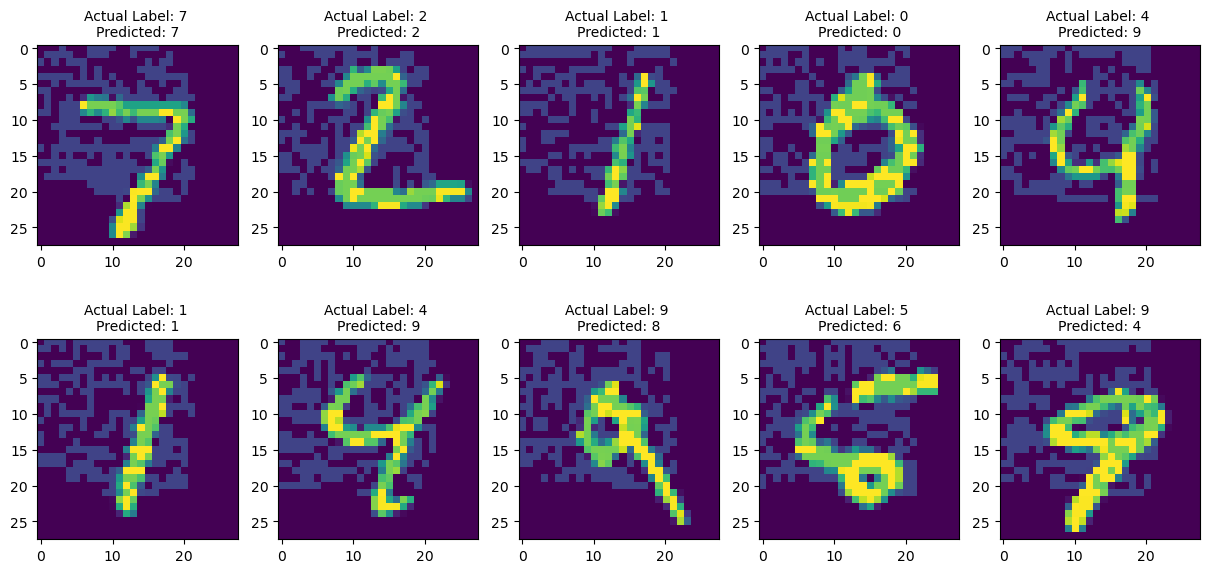

In [18]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  #im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label.argmax()} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=10)

Evaluate accuracy on adversarial test data and calculate average perturbation.

In [19]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 52.48%
Average perturbation: 0.07


##Training the detector

We create the second model using Keras API with the same strucure of the classifier. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics. This model will be used to classify between ordinary samples and perturbated ones

In [21]:
detector_model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
loss_ = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
detector_model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy']);

create samples of perturbaed using the attacker.

In [23]:
x_train_adv = attack_fgsm.generate(x_train[:5000])
nb_train = x_train[:5000].shape[0]

x_train_detector = np.concatenate((x_train[:5000], x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

2025-01-14 09:27:33.542977: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_3/kernel/Assign' id:633 op device:{requested: '', assigned: ''} def:{{{node conv2d_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_3/kernel, conv2d_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [24]:
# As FGSM is fast enough so we do no save the data.
# np.savez('./fgsm_generated_data/fgsm_attach_generated_MNIST10_train.npz', 
#          x_train_detector=x_train_detector, y_train_detector = y_train_detector)

# training_generated_data = np.load('./fgsm_generated_data/fgsm_attach_generated_MNIST10_train.npz')
# x_train_detector, y_train_detector = training_generated_data['x_train_detector'], training_generated_data['y_train_detector']
# x_train_detector.shape, y_train_detector.shape

In [25]:
detector_model.fit(x_train_detector, y_train_detector, epochs=3)

Train on 10000 samples
Epoch 1/3


2025-01-14 09:29:04.847138: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:830 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-01-14 09:29:04.918441: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/Adam/conv2d_5/kernel/m/Assign' id:980 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/conv2d_5/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/conv2d_5/kernel/m, training_2/Adam/conv2d_5/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error

10000/10000 [==============================] - 7s 697us/sample - loss: 0.0467 - accuracy: 0.9803
Epoch 2/3
10000/10000 [==============================] - 6s 607us/sample - loss: 4.3204e-05 - accuracy: 1.0000
Epoch 3/3
10000/10000 [==============================] - 7s 655us/sample - loss: 1.5003e-05 - accuracy: 1.0000


In [27]:
# detector_model.save('./../models/fsgm_mnist10_model.keras')
# detector_model = tf.keras.models.load_model('./../models/fsgm_mnist10_model.keras')
# detector_model.summary()

### creating samples to test our detector model.

In [28]:
x_test = x_test[:100]
y_test = y_test[:100]

x_test_adv = attack_fgsm.generate(x_test)
nb_test = x_test.shape[0]

x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test), np.array([[0,1]]*nb_test)), axis=0)

x_test_detector.shape, y_test_detector.shape

((200, 28, 28, 1), (200, 2))

### Evaluate detector model accuracy on combined test data.

In [29]:
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2025-01-14 09:30:09.261282: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:830 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on test data: 100.00%


In [30]:
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [31]:
# detector.fit(x_train, y_train, batch_size = 128, nb_epochs= 5)
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

### Evaluating the detector

#### Apply the detector to the adversarial test data:

In [32]:
_, is_adversarial = detector.detect(x_test_adv)
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 100
Not flagged: 0


2025-01-14 09:30:54.700996: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_3/Softmax' id:754 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### Apply the detector to the first 100 original test images:

In [33]:
_, is_adversarial = detector.detect(x_test[:100])
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Original test data (first 100 images):
Flagged: 0
Not flagged: 100


### Evaluate the detector for different attack strengths eps (Note: for the training of detector, eps=0.25 was used)

In [34]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

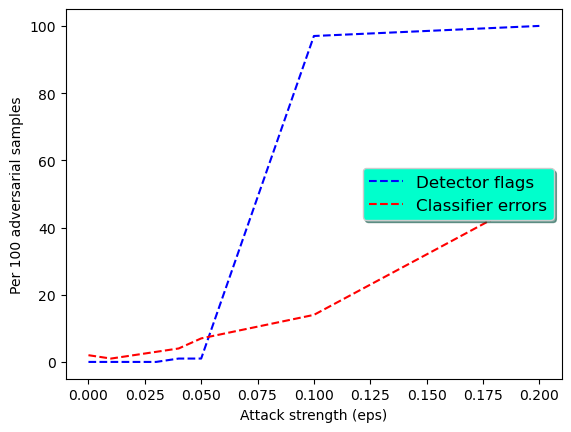

In [35]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

### Summary: 

The Fast Gradient Sign Method (FGSM) is an adversarial attack that perturbs input data to mislead machine learning models. It generates adversarial examples by adding a small, directed perturbation to each input, calculated using the gradient of the loss function with respect to the input. The perturbation is controlled by a parameter $ϵ$, which determines the magnitude of the change. Specifically, the perturbed input is given by $x′=x+ϵ⋅sign(∇xJ(θ,x,y))$. A larger $ϵ$ increases the perturbation, making the attack more likely to succeed but potentially more noticeable.